In [57]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from collections import defaultdict
from tqdm.notebook import tqdm

In [92]:
# генерируем датафрейм
sample_size = 1000

metric = np.random.normal(1, 5, sample_size).reshape(1,sample_size)
user_id = np.arange(sample_size).reshape(1,sample_size)
starta_1 = np.random.randint(5, size=sample_size).reshape(1,sample_size)
starta_2 = np.random.randint(3, size=sample_size).reshape(1,sample_size)
cols = ['user_id', 'metric', 'starta_1', 'starta_2']

df = pd.DataFrame(
    data=np.concatenate((user_id, metric, starta_1, starta_2), axis=0).T,
    columns=cols
    )
df

,user_id,metric,starta_1,starta_2
0,0.0,-1.589864,4.0,1.0
1,1.0,1.817269,1.0,1.0
2,2.0,2.874392,2.0,0.0
3,3.0,5.464629,4.0,1.0
4,4.0,-6.477212,4.0,0.0
...,...,...,...,...
995,995.0,-3.758789,0.0,2.0
996,996.0,2.952307,2.0,1.0
997,997.0,7.350143,4.0,0.0
998,998.0,3.076138,1.0,2.0


In [118]:
titlesize = 24
labelsize = 22
legendsize = 22
xticksize = 18
yticksize = xticksize

plt.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
plt.rcParams['legend.handletextpad'] = 0.5
plt.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
plt.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
plt.rcParams['font.size'] = 12
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['axes.labelsize'] = labelsize
plt.rcParams['axes.titlesize'] = titlesize
plt.rcParams['figure.figsize'] = (15, 6)

plt.rc('xtick', labelsize=xticksize)
plt.rc('ytick', labelsize=yticksize)
plt.rc('legend', fontsize=legendsize)

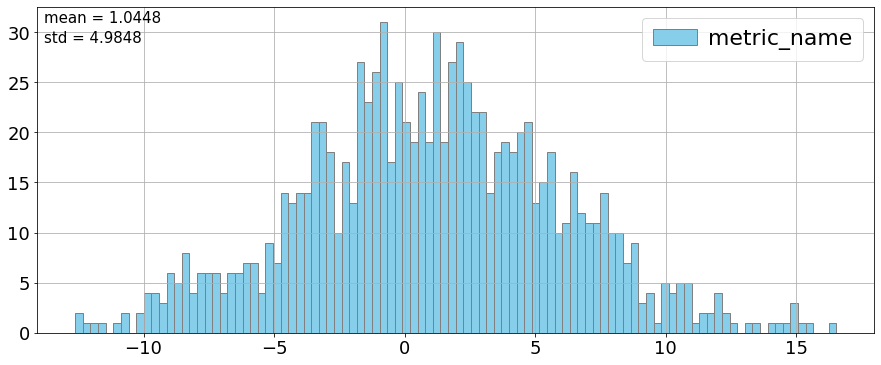

In [142]:
# посмотрим на распределение сырых данных
data_mean = round(np.mean(df['metric']), 4)
data_std = round(np.std(df['metric']), 4)
plt.hist(df['metric'], color='skyblue', ec='grey', bins=100)
plt.legend(['metric_name'])
plt.text(-13.8, 31, f'mean = {data_mean}', size=15, color='black')
plt.text(-13.8, 29, f'std = {data_std}', size=15, color='black')
plt.grid()
plt.show()

In [153]:
# попробуем снизить дисперсию данных за счет стратификации
# TODO изменить функцию так, чтобы не было разбиения на тест и контроль,
def stratified_helper(data, strat_columns, val_list, group_size, weight):
    strat_df = data[data[strat_columns].isin(val_list).all(axis=1)].reset_index(drop=True)
    ab_group_size = int(2*group_size*weight)
    #print(len(strat_df), ab_group_size)
    random_indexes_ab = np.random.choice([i for i in range(len(strat_df))], ab_group_size, False)
    a_indexes = random_indexes_ab[:int(ab_group_size/2)]
    b_indexes = random_indexes_ab[int(ab_group_size/2):]
    a_random_strata_df = strat_df.iloc[a_indexes,:]
    b_random_strata_df = strat_df.iloc[b_indexes,:]
    #print(len(strat_df), len(a_random_strata_df), len(b_random_strata_df))
    
    return a_random_strata_df, b_random_strata_df

def select_stratified_groups(data, strat_columns, group_size, weights=None, seed=None):
    """Подбирает стратифицированные группы для эксперимента.

    data - pd.DataFrame, датафрейм с описанием объектов, содержит атрибуты для стратификации.
    strat_columns - List[str], список названий столбцов, по которым нужно стратифицировать.
    group_size - int, размеры групп.
    weights - dict, словарь весов страт {strat: weight}, где strat - либо tuple значений элементов страт,
        например, для strat_columns=['os', 'gender', 'birth_year'] будет ('ios', 'man', 1992), либо просто строка/число.
        Если None, определить веса пропорционально доле страт в датафрейме data.
    seed - int, исходное состояние генератора случайных чисел для воспроизводимости
        результатов. Если None, то состояние генератора не устанавливается.

    return (data_pilot, data_control) - два датафрейма того же формата, что и data
        c пилотной и контрольной группами.
    """
    # YOUR_CODE_HERE
    np.random.seed(seed)
    
    pilot = pd.DataFrame(columns=strat_columns)
    control = pd.DataFrame(columns=strat_columns)
    if weights:
        for strat, weight in weights.items():
            if isinstance(strat, str):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
                
            a_random_strata_df = stratified_helper(data, strat_columns, val_list, group_size, weight)[0]
            b_random_strata_df = stratified_helper(data, strat_columns, val_list, group_size, weight)[1]
            
            control = pd.concat([control, a_random_strata_df], ignore_index=True)
            pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True) 
    else:
        strat_dict = data.groupby(strat_columns).count().iloc[:,0].to_dict()
        #display(strat_dict)
        len_data = len(df)
        #print(len_data)
        strat_dict_shares = {strata:share/len_data for (strata, share) in strat_dict.items()}
        #display(strat_dict_shares)
        for strat, weight in strat_dict_shares.items():
            if isinstance(strat, str):
                val_list = []
                val_list += [strat]
            else:
                val_list = list(strat)
            a_random_strata_df = stratified_helper(data, strat_columns, val_list, group_size, weight)[0]
            b_random_strata_df = stratified_helper(data, strat_columns, val_list, group_size, weight)[1]
            
            control = pd.concat([control, a_random_strata_df], ignore_index=True)
            pilot = pd.concat([pilot, b_random_strata_df], ignore_index=True) 
    return (pilot, control)

In [163]:
pilot = select_stratified_groups(df, ['starta_1', 'starta_2'], 500, weights=None, seed=42)[0]
control = select_stratified_groups(df, ['starta_1', 'starta_2'], 500, weights=None, seed=42)[1]

In [164]:
pilot.groupby(['starta_1', 'starta_2'])['user_id'].count().to_frame()

user_id
starta_1 starta_2         
0.0      0.0           107
         1.0            20
         2.0            18
1.0      0.0             9
         1.0           114
         2.0            15
2.0      0.0            19
         1.0            15
         2.0            86
3.0      0.0            19
         1.0            16
         2.0            17
4.0      0.0            15
         1.0             9
         2.0            25

In [165]:
control.groupby(['starta_1', 'starta_2'])['user_id'].count().to_frame()

user_id
starta_1 starta_2         
0.0      0.0           104
         1.0            11
         2.0            19
1.0      0.0            14
         1.0           102
         2.0            14
2.0      0.0            21
         1.0            18
         2.0            92
3.0      0.0            17
         1.0            17
         2.0            13
4.0      0.0            21
         1.0            14
         2.0            19

In [8]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)


def check_mannwhitneyu(a, b, alpha=0.05):
    """Тест Манн-Уитни. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.mannwhitneyu(a, b, alternative='two-sided')
    return int(pvalue < alpha)


def check_bootstrap(a, b, func=np.mean, B=1000, alpha=0.05):
    """Бутстрап. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(len(a), B))
    b_bootstrap = np.random.choice(b, size=(len(b), B))
    list_diff = func(a_bootstrap, axis=0) - func(b_bootstrap, axis=0)
    left_bound = np.quantile(list_diff, alpha / 2)
    right_bound = np.quantile(list_diff, 1 - alpha / 2)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res

In [54]:
res = []
for _ in tqdm(range(100)):
    pval = []
    for _ in range(1000):
        a = np.random.normal(0, 1, 1000)
        b = np.random.normal(0.02, 1, 1000)
        pval.append(check_ttest(a, b))
    res.append(np.mean(pval))

  0%|          | 0/100 [00:00<?, ?it/s]

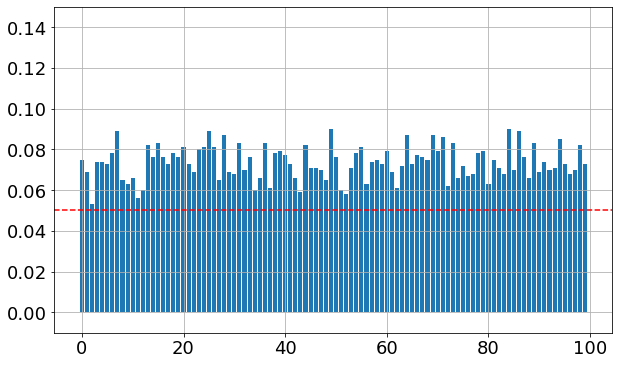

In [55]:
plt.bar([i for i in range(len(res))], res)
plt.ylim([-0.01, 0.15])
plt.axhline(y = 0.05, color = 'r', linestyle = '--')
plt.grid()
plt.show()

In [56]:
np.mean(res)

0.07352999999999998